In [145]:
from __future__ import print_function
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import numpy as np
import pandas as pd

from rocket import Rocket

import random

In [146]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        d = 16
        self.fc1 = nn.Linear(5, d)
        self.fc2 = nn.Linear(d, d)
        self.fc3 = nn.Linear(d, 2)
        
        a = (12/(5+d))**0.5
        nn.init.uniform_(self.fc1.weight, a=-a, b=a)
        
        a = (12/(d+d))**0.5
        nn.init.uniform_(self.fc2.weight, a=-a, b=a)
        
        a = (6/(d+2))**0.5
        nn.init.uniform_(self.fc3.weight, a=-a, b=a)
        
    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        
        return x
    
class MyDataset(data.Dataset):
    
    def __init__(self, state_csv, control_csv, transform=None):
        
        df_s = pd.read_csv(state_csv)
        df_c = pd.read_csv(control_csv)
        
        #normalize by (df-mean)/std
        self.s_mean, self.s_std = df_s.mean(), df_s.std()
        self.c_mean, self.c_std = df_c.mean(), df_c.std()
        
        n_df_s = (df_s - df_s.mean())/df_s.std()
        #n_df_c = (df_c - df_c.mean())/df_c.std()
        
        #normalize control range from -1 to 1
        #self.c_max = n_df_c.max()
        #self.c_min = n_df_c.min()
        
        #n2_df_c = 2*(n_df_c-n_df_c.min())/(n_df_c.max()-n_df_c.min()) - 1
        n_df_c = df_c
        n_df_c['0'] = 2*n_df_c['0']-1 #from [0,1] to [-1,1]
        #n_df_c['1'] = 2*n_df_c['1']/np.pi #from [-pi/2, pi/2] to [-1,1]
        self.u2_nond = (np.pi/8)
        n_df_c['1'] = n_df_c['1']/self.u2_nond #from [-u2_nond, u2_nond] to [-1,1]
        #n_df_c['1'] = (n_df_c['1']-n_df_c['1'].mean())/n_df_c['1'].std()
        
        self.df_s = torch.FloatTensor(n_df_s.values)
        self.df_c = torch.FloatTensor(n_df_c.values)
        
        self.length = len(self.df_s)
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        
        sample = {'s': self.df_s[index], 'c': self.df_c[index]}
        
        return sample
    
    def normalize_s(self, state):
        return ((state[i] - self.s_mean[i])/self.s_std[i] for i in range(5))
    
    def normalize_c(self, control):
        
        raise NotImplementedError
        
        #return ((control[i] - self.c_mean[i])/self.c_std[i] for i in range(2))
    
    def denormalize_c(self, nn_c):
        #undo the min max
        
        #n_c = [0.5*(nn_c[i]+1)*(self.c_max[i]-self.c_min[i]) + self.c_min[i] for i in range(2)]
        
        #undo the std and mean
        #c = (n_c[i]*self.c_std[i] + self.c_mean[i] for i in range(2))
        
        c1 = (nn_c[0] + 1)/2
        #c2 = (nn_c[1]*self.c_std[1] + self.c_mean[1])
        
        c2 = nn_c[1]*self.u2_nond
        
        return c1, c2
    
    def in_training_region(self, point, normalized=True):
        if normalized==False:
            point = self.normalize_s(point)
            
        for i, p in enumerate(point):
            
            if p < self.df_s[:,i].min():
                
                print(f'min: {i}')
                return False
            if p > self.df_s[:,i].max():
                print(f'max: {i}')
                return False
        
        return True
            
        

In [147]:
net = Net()

In [148]:
print(net)

Net(
  (fc1): Linear(in_features=5, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)


In [383]:
params = list(net.parameters())

In [384]:
params;

In [385]:
sum(p.numel() for p in net.parameters() if p.requires_grad)

402

In [386]:
net.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [387]:
net.eval()

Net(
  (fc1): Linear(in_features=5, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

In [388]:
path_s = 'data_apollo/df_s_full.csv'
path_c = 'data_apollo/df_c_full.csv'
full_data = MyDataset(path_s, path_c)

In [13]:
train_size = int(0.95 * len(full_data))
val_size = len(full_data) - train_size
train_dataset, validate_dataset = torch.utils.data.random_split(full_data, [train_size, val_size])

In [14]:
len(full_data)

1005131

In [15]:
len(train_dataset)

954874

In [16]:
len(validate_dataset)

50257

In [17]:
batch_size = 8
train_dl = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_dl = data.DataLoader(validate_dataset, batch_size=batch_size, shuffle=True)

In [18]:
train_dl

In [19]:
validate_dl

In [83]:

def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

In [84]:
net.zero_grad()

In [87]:

optimizer = optim.SGD(net.parameters(), lr = 0.005, momentum=0.9)
criterion = nn.MSELoss()


train_step = make_train_step(model=net, loss_fn=criterion, optimizer=optimizer)
losses = []
val_losses = []

n_epochs = 2

In [154]:
print("Started Training")
for epoch in range(n_epochs):
    episode_loss_train = 0
    episode_loss_val   = 0
    
    for batch in train_dl:

        state = batch['s']
        control = batch['c']
        
        loss = train_step(state, control)
        
        losses.append(loss)
        episode_loss_train += loss
        
    with torch.no_grad():
        for batch in validate_dl:
            
            net.eval()
            
            state = batch['s']
            control = batch['c']

            c_hat = net(state)
            
            val_loss = criterion(control, c_hat)
            
            val_losses.append(val_loss.item())
            
            episode_loss_val += val_loss.item()
            
            
    print(f"""Epoch: {epoch}, Loss: {sum(losses)/len(losses):.6f}, Val_loss: {sum(val_losses)/len(val_losses):.6f}, Epoch Loss: {episode_loss_train/len(losses):.6f}, Epoch Val Loss: {episode_loss_val/len(val_losses):.6f}""")

print('')

print("********Finished Training*********")

Started Training
Epoch: 0, Loss: 0.771906, Val_loss: 0.000049, Epoch Loss: 0.766563, Epoch Val Loss: 0.000016

********Finished Training*********


In [156]:
d = next(iter(train_dl))

In [157]:
net(d['s'])

tensor([[-3.2003e-01, -1.5557e-02],
        [-1.6166e-01, -3.7180e-02],
        [-3.2043e-01, -1.7670e-02],
        [-3.2153e-01, -3.8619e-03],
        [-2.6551e-01, -1.7331e-04],
        [-2.5414e-01,  1.0982e-01],
        [-1.5349e-01,  1.1306e-02],
        [-3.9722e-01, -5.6281e-03]], grad_fn=<TanhBackward>)

In [158]:
d['c']

tensor([[-0.3171, -0.0124],
        [-0.1643, -0.0183],
        [-0.3181, -0.0145],
        [-0.3213, -0.0008],
        [-0.2662,  0.0011],
        [-0.2579,  0.1168],
        [-0.1470,  0.0082],
        [-0.4002, -0.0017]])

In [159]:
abs(d['c']-net(d['s']))

tensor([[0.0029, 0.0032],
        [0.0026, 0.0188],
        [0.0023, 0.0032],
        [0.0002, 0.0031],
        [0.0007, 0.0012],
        [0.0037, 0.0070],
        [0.0064, 0.0031],
        [0.0030, 0.0039]], grad_fn=<AbsBackward>)

In [160]:
torch.save(net.state_dict(), 'model.pt')

In [161]:
with torch.no_grad():
    def simulate_net(rocket, model, dataset):

        t = np.array([0,])
        dt = 1

        x, z, vx, vz, m = (np.array([s,]) for s in rocket.s_0)
        sf = (x[-1], z[-1], vx[-1], vz[-1], m[-1])

        u1, u2 = np.array([]), np.array([])
        
        while True:
            if z[-1] < 0: print('z<0'); break
            if z[-1] > 2000: print('z>2000'); break
            if abs(x[-1]) > 800: print('abs(x)>800'); break
            if abs(vx[-1]) > 20: print('abs(vx)>20'); break
            if vz[-1] < -100: print('vz<-100'); break
            if vz[-1] > 30: print('vz>30'); break
            if t[-1] > 1500: print('t>1500'); break
            
            #if not dataset.in_training_region(sf, normalized = False): print('minmax'); break
            if (x[-1]**2 + z[-1]**2)**0.5 < 10: print('fin'); break
            sf = (x[-1], z[-1], vx[-1], vz[-1], m[-1])


            #evaluate the model
            n_sf = tuple(list(dataset.normalize_s(sf)))

            n_uf = tuple(model(torch.FloatTensor(n_sf)).detach().numpy())

            uf = tuple(list(dataset.denormalize_c(n_uf)))


            new_state = rocket.propagate(sf, uf, dt=dt)

            x = np.append(x, new_state[0])
            z = np.append(z, new_state[1])
            vx= np.append(vx, new_state[2])
            vz= np.append(vz, new_state[3])
            m = np.append(m, new_state[4])
            t = np.append(t, t[-1]+dt)

            u1 = np.append(u1, uf[0])
            u2 = np.append(u2, uf[1])


            #print(f't: {t[-1]:.1f}, x:{x[-1]:.1f}, z:{z[-1]:.1f}, u1:{u1[-1]:.2f}, u2:{u2[-1]:.2f}')

        u1 = np.append(u1, u1[-1])
        u2 = np.append(u2, u2[-1])    
            
        return (t, x, z, vx, vz, m, u1, u2)

def simulate_no_thrust(rocket):

    t = [0,]
    dt = 1

    x, z, vx, vz, m = ([s,] for s in rocket.s_0)

    u1, u2 = [], []

    while z[-1] > 0 and t[-1] < 300:
        sf = (x[-1], z[-1], vx[-1], vz[-1], m[-1])

        new_state = rocket.propagate(sf, (0,0), dt=dt)

        x.append(new_state[0])
        z.append(new_state[1])
        vx.append(new_state[2])
        vz.append(new_state[3])
        m.append(new_state[4])
        t.append(t[-1]+dt)

        u1.append(0)
        u2.append(0)


        #print(f't: {t[-1]:.1f}, x:{x[-1]:.1f}, z:{z[-1]:.1f}, u1:{u1[-1]:.2f}, u2:{u2[-1]:.2f}')
    
    u1.append(u1[-1])
    u2.append(u2[-1])   

    return (t, x, z, vx, vz, m, u1, u2)    
        

Rocket 
Initial State: (198.97690979706948, 1087.8118967503278, -2.404752937582451, -26.41487833844671, 8626.457898239496)
fin


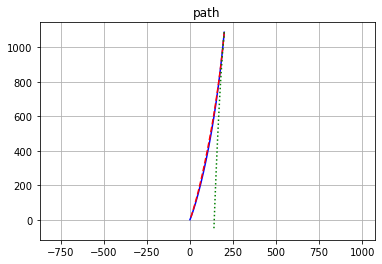

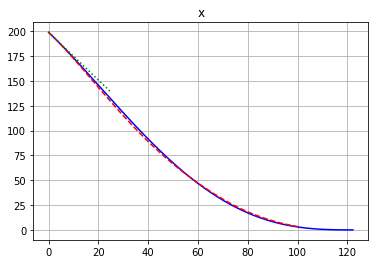

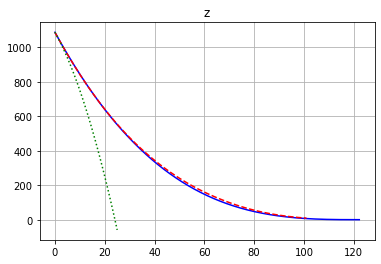

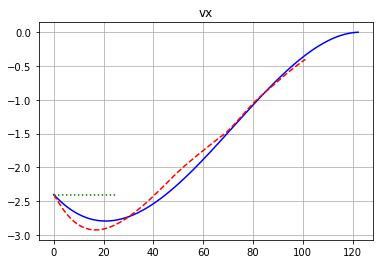

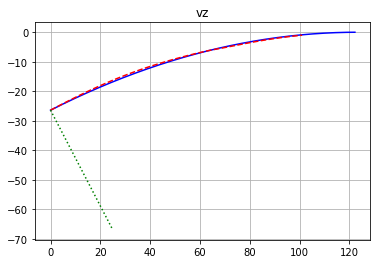

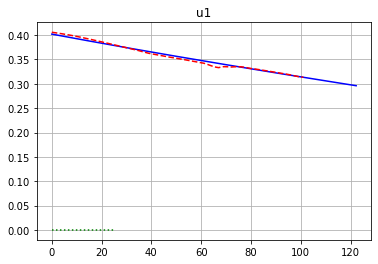

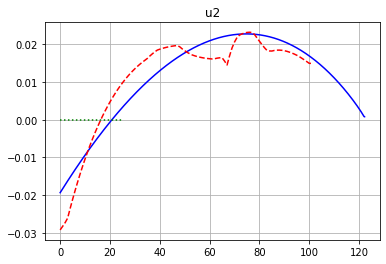

In [392]:
r = Rocket(disperse=True)

s0 = [s for s in r.s_0]
s0[3] = -abs(s0[3])

r = Rocket(*s0, disperse=False)

r.lunar_guidance_live(h_ratio=2)
print(r)

with torch.no_grad():
    (t_net, x_net, z_net, vx_net, vz_net, m_net, u1_net, u2_net) = simulate_net(r, net, full_data)
    
(t_no, x_no, z_no, vx_no, vz_no, m_no, u1_no, u2_no) = simulate_no_thrust(r)

plt.plot(r.x, r.z, 'b-')
plt.plot(x_net, z_net, 'r--')
plt.plot(x_no, z_no, 'g:')
ax = plt.gca()
ax.set_aspect('equal', 'datalim')
plt.title('path')
plt.grid()
plt.show()


plt.plot(r.t, r.x, 'b-')
plt.plot(t_net, x_net, 'r--')
plt.plot(t_no, x_no, 'g:')
plt.grid()
plt.title('x')
plt.show()

plt.plot(r.t, r.z, 'b-')
plt.plot(t_net, z_net, 'r--')
plt.plot(t_no, z_no, 'g:')
plt.grid()
plt.title('z')
plt.show()

plt.plot(r.t, r.vx, 'b-')
plt.plot(t_net, vx_net, 'r--')
plt.plot(t_no, vx_no, 'g:')
plt.grid()
plt.title('vx')
plt.show()


plt.plot(r.t, r.vz, 'b-')
plt.plot(t_net, vz_net, 'r--')
plt.plot(t_no, vz_no, 'g:')
plt.grid()
plt.title('vz')
plt.show()



plt.plot(r.t, r.u1_mag, 'b-')
plt.plot(t_net, u1_net, 'r--')
plt.plot(t_no, u1_no, 'g:')
plt.grid()
plt.title('u1')
plt.show()


plt.plot(r.t, r.u2_angle, 'b-')
plt.plot(t_net, u2_net, 'r--')
plt.plot(t_no, u2_no, 'g:')
plt.grid()
plt.title('u2')
plt.show()



In [163]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

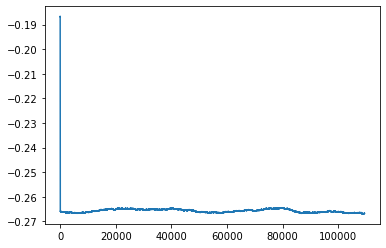

In [164]:
plt.plot(np.log(moving_average(losses[1:],10000)))

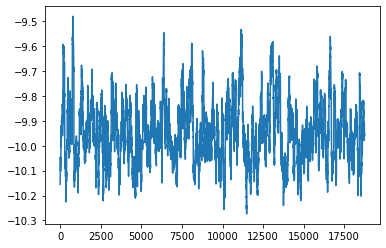

In [165]:
plt.plot(np.log(moving_average(val_losses,100)))

In [165]:
net(train_dataset[0]['s'])

tensor([-0.4044, -0.0094], grad_fn=<TanhBackward>)

In [166]:
train_dataset[0]['c']

tensor([-0.4048, -0.0103])

In [167]:
for i in range(10):
    print(net(train_dataset[i]['s']), train_dataset[i]['c'])

tensor([-0.4044, -0.0094], grad_fn=<TanhBackward>) tensor([-0.4048, -0.0103])
tensor([-0.4668,  0.0065], grad_fn=<TanhBackward>) tensor([-0.4639,  0.0061])
tensor([-0.2781,  0.0162], grad_fn=<TanhBackward>) tensor([-0.2806,  0.0181])
tensor([-0.3448,  0.0083], grad_fn=<TanhBackward>) tensor([-0.3446,  0.0048])
tensor([-0.3831,  0.0015], grad_fn=<TanhBackward>) tensor([-3.8533e-01,  2.3858e-04])
tensor([-0.4114, -0.0024], grad_fn=<TanhBackward>) tensor([-0.4038, -0.0103])
tensor([-0.4179,  0.0112], grad_fn=<TanhBackward>) tensor([-0.4164,  0.0124])
tensor([-0.4706,  0.0013], grad_fn=<TanhBackward>) tensor([-0.4681,  0.0029])
tensor([-0.3931,  0.0060], grad_fn=<TanhBackward>) tensor([-0.3927,  0.0061])
tensor([-0.2830,  0.0152], grad_fn=<TanhBackward>) tensor([-0.2828,  0.0144])


In [166]:
def tensor_dynamics(state, dt = 1):
    x = state[0]
    z = state[1]
    vx = state[2]
    vz = state[3]
    m = state[4]
    
    #non dimensionalize
    n_state = (state - torch.tensor(full_data.s_mean))/torch.tensor(full_data.s_std)
    
    # predict using net
    u = net.forward(n_state)
    
    #de-normalize
    u1 = (u[0] + 1)/2
    u2 = (u[1]*np.pi/8)
    
    #dynamics
    g = 1.6229
    c1 = 44000
    c2 = 311*9.81
    
    dx = vx
    dz = vz
    dvx = c1*(u1/m)*torch.sin(u2)
    dvz = c1*(u1/m)*torch.cos(u2) - g
    dm  = -(c1/c2)*u1
    
    #update state
    x = x + dx*dt
    z = z + dz*dt
    vx = vx + dvx*dt
    vz = vz + dvz*dt
    m = m + dm*dt
    
    #return new state
    new_state = torch.stack((x, z, vx, vz, m))
    
    return new_state
    
    

In [167]:
torch.tensor(full_data.s_mean)

tensor([-4.8342e-01,  3.4932e+02,  1.7036e-03, -5.6301e+00,  9.1971e+03])

In [168]:
r = Rocket()
state = torch.tensor(r.s_0, requires_grad=True)

In [169]:
state

tensor([ 1.3896e+02,  1.0119e+03, -5.0824e+00, -1.7843e+01,  1.0469e+04],
       requires_grad=True)

In [170]:
state = tensor_dynamics(state)

In [171]:
state

tensor([ 1.3388e+02,  9.9402e+02, -4.9786e+00, -1.7654e+01,  1.0463e+04],
       grad_fn=<StackBackward>)

In [512]:
def forward_simulate_net(rocket, model, dataset):
        
        t = 0
        dt = 1
        
        state = torch.tensor(r.s_0)
        
        min_dist_sq = state[0]**2 + state[1]**2
        min_velo_sq = state[2]**2 + state[3]**2
        prop_frac = torch.tensor(1)
        
        m0 = state[4]
        
        ret = dict()
        ret['success'] = False
        ret['cost'] = 1
        ret['reason'] = 'other'

        
        while True:
            if state[1] < 0: 
                #print('z<0');
                ret['reason'] = 'z<0'
                ret['cost'] = prop_frac
                ret['success'] = False
                return ret
            if t > 1000:
                ret['reason'] = 't_max'
                break
           
            state = tensor_dynamics(state, dt) #updates state
            t += dt
            
            dist_sq = state[0]**2 + state[1]**2
            velo_sq = state[2]**2 + state[3]**2
            
            #update min_dist
            if min_dist_sq > dist_sq:
                min_dist_sq = dist_sq
                min_velo_sq = velo_sq
                prop_frac = 1 - state[4]/m0
                
            if dist_sq > 2*min_dist_sq:
                ret['reason'] = 'dist_sq > 2*min_dist_sq'
                break
                        
            if dist_sq < 10**2 and velo_sq < 0.7**2:
                ret['cost'] = prop_frac
                ret['success'] = True
                return ret #return propellant mass usage
        
        ## compute losses
        #if its here, it didnt succeed
        ret['cost'] = torch.tensor(1.)
        return ret #1 + torch.log(1+torch.log(min_dist_sq**0.5/10 + min_velo_sq**0.5/0.7))

In [513]:
num = 50
res = [None]*num
for ind in range(num):
    r = Rocket()
    res[ind] = forward_simulate_net(r, net, full_data)

In [514]:
sum([r['cost'].item() for r in res])/num

0.29621342301368714

In [515]:
len([1 for r in res if r['success']])/num

0.76

In [516]:
r = Rocket()
print(forward_simulate_net(r, net, full_data))

{'success': True, 'cost': tensor(8.4779e-02, grad_fn=<RsubBackward1>), 'reason': 'other'}


In [486]:
from torchviz import make_dot


In [487]:
s = torch.tensor(list(full_data.normalize_s(torch.tensor(r.s_0))))
s

tensor([3.0651e+00, 3.7712e+00, -5.0864e+00, 2.6650e-01, 1.4538e+00])

In [488]:
#make_dot(net(s))

In [489]:
r = Rocket()
print(forward_simulate_net(r, net, full_data))
#make_dot(forward_simulate_net(r, net, full_data))

{'success': True, 'cost': tensor(9.3139e-02, grad_fn=<RsubBackward1>), 'reason': 'other'}


In [294]:
list(net.parameters())

[Parameter containing:
 tensor([[-0.2200, -0.4429, -0.3158,  0.3587,  0.0117],
         [-0.3612, -1.0351, -0.2580, -0.7177,  0.0197],
         [-0.0350, -0.4217,  0.0785,  0.5305, -0.0256],
         [-0.0300,  0.3167, -0.1377, -0.3215, -0.0097],
         [ 0.2304, -0.3266,  0.2965,  0.3894,  0.0103],
         [ 0.0045,  0.3139, -0.0162, -0.3872,  0.3383],
         [-0.1184, -0.4620,  0.1296,  0.6252, -0.0913],
         [-0.1872, -0.3167, -0.1228,  0.4452, -0.5790],
         [ 0.8124,  0.4600,  0.2330, -0.3294, -0.0379],
         [ 0.1706, -0.6590,  0.2629,  0.2579, -0.0747],
         [ 0.2014,  0.1909,  0.1788,  0.3539, -0.0590],
         [ 0.0226,  0.4489,  0.1853, -0.2051, -0.0039],
         [ 0.3644, -0.2773,  0.5804,  0.6994, -0.4489],
         [ 0.2181, -1.0323,  0.0813, -0.3348,  0.0029],
         [ 0.3308, -0.7880,  0.2628, -0.7972,  0.1698],
         [ 0.1824, -0.5027,  0.1811, -0.2607, -0.0340]], requires_grad=True),
 Parameter containing:
 tensor([-0.6533, -0.1335, -0.2444, 

In [529]:

optimizer2 = optim.SGD(net.parameters(), lr = 0.00005, momentum=0.9)

n_epochs = 3
val_num = 20
batch_size = 10

In [540]:
losses = []

val_res = [None,]*val_num

print("Started Training v2")
for epoch in range(n_epochs):
    episode_loss_train = 0
    episode_loss_val   = 0
    
    epoch_loss = [None]*batch_size
    for ind in range(batch_size):
        

        r = Rocket(disperse=True)
        #print(r)
        
        #set into training mode
        net.train()
        
        #forward simulate
        optimizer2.zero_grad()
        res = forward_simulate_net(r, net, full_data)
        
        epoch_loss[ind] = res['cost']
        
    
    print([e.item() for e in epoch_loss])
    loss = sum(epoch_loss)/batch_size
    loss.backward()
        
    # Updates parameters and zeroes gradients
    optimizer2.step()
        
        
    losses.append(loss.item())
    episode_loss_train += loss.item()
        
    with torch.no_grad():
        
        for ind in range(val_num):
            r = Rocket(disperse=True)
            
            val_res[ind] = forward_simulate_net(r, net, full_data)
            
        avg_cost = sum([r['cost'] for r in val_res if r['success']])/val_num
            
        success_rate = len([1 for r in val_res if r['success']])
            
            
            
            
    print(f"""Epoch: {epoch}, Loss: {sum(losses)/len(losses):.6f}, avg_cost if success: {avg_cost:.6f}, success rate: {success_rate} of {val_num}""")

    
print('')

print("********Finished Training*********")

Started Training v2
[0.06470787525177002, 0.1017102599143982, 0.052135586738586426, 0.2499675154685974, 0.10105669498443604, 0.0965731143951416, 1.0, 1.0, 0.0682990550994873, 0.05280023813247681]
Epoch: 0, Loss: 0.278725, avg_cost (success): 0.127608, success rate: 17 of 20
[1.0, 0.20068711042404175, 1.0, 0.2403097152709961, 0.23009538650512695, 0.20846611261367798, 0.22131693363189697, 1.0, 0.19520634412765503, 0.06403326988220215]
Epoch: 1, Loss: 0.357368, avg_cost (success): 0.141746, success rate: 19 of 20
[0.04482460021972656, 0.17375940084457397, 0.2508479356765747, 0.1990782618522644, 0.2792932987213135, 0.3282340168952942, 0.26174062490463257, 0.30047887563705444, 0.21732115745544434, 0.24828392267227173]
Epoch: 2, Loss: 0.315041, avg_cost (success): 0.109642, success rate: 12 of 20

********Finished Training*********


In [541]:
sum(epoch_loss)

tensor(2.3039e+00, grad_fn=<AddBackward0>)

In [542]:
val_res

[{'success': True, 'cost': tensor(2.4211e-01), 'reason': 'other'},
 {'success': False,
  'cost': tensor(1.0000e+00),
  'reason': 'dist_sq > 2*min_dist_sq'},
 {'success': False,
  'cost': tensor(1.0000e+00),
  'reason': 'dist_sq > 2*min_dist_sq'},
 {'success': False,
  'cost': tensor(1.0000e+00),
  'reason': 'dist_sq > 2*min_dist_sq'},
 {'success': False,
  'cost': tensor(1.0000e+00),
  'reason': 'dist_sq > 2*min_dist_sq'},
 {'success': True, 'cost': tensor(2.2186e-01), 'reason': 'other'},
 {'success': False,
  'cost': tensor(1.0000e+00),
  'reason': 'dist_sq > 2*min_dist_sq'},
 {'success': True, 'cost': tensor(5.3590e-02), 'reason': 'other'},
 {'success': True, 'cost': tensor(3.0929e-01), 'reason': 'other'},
 {'success': False,
  'cost': tensor(1.0000e+00),
  'reason': 'dist_sq > 2*min_dist_sq'},
 {'success': True, 'cost': tensor(2.3084e-01), 'reason': 'other'},
 {'success': True, 'cost': tensor(6.1950e-02), 'reason': 'other'},
 {'success': True, 'cost': tensor(3.4639e-01), 'reason': '

In [533]:
list(net.parameters())

[Parameter containing:
 tensor([[-2.1997e-01, -4.4291e-01, -3.1581e-01, 3.5869e-01, 1.1713e-02],
         [-3.6117e-01, -1.0351e+00, -2.5802e-01, -7.1772e-01, 1.9724e-02],
         [-3.4953e-02, -4.2168e-01, 7.8549e-02, 5.3050e-01, -2.5599e-02],
         [-2.9962e-02, 3.1667e-01, -1.3773e-01, -3.2150e-01, -9.7404e-03],
         [2.3036e-01, -3.2659e-01, 2.9652e-01, 3.8943e-01, 1.0265e-02],
         [4.5415e-03, 3.1386e-01, -1.6213e-02, -3.8724e-01, 3.3834e-01],
         [-1.1836e-01, -4.6202e-01, 1.2960e-01, 6.2524e-01, -9.1260e-02],
         [-1.8718e-01, -3.1669e-01, -1.2283e-01, 4.4521e-01, -5.7905e-01],
         [8.1235e-01, 4.5995e-01, 2.3303e-01, -3.2943e-01, -3.7937e-02],
         [1.7056e-01, -6.5903e-01, 2.6289e-01, 2.5790e-01, -7.4668e-02],
         [2.0137e-01, 1.9091e-01, 1.7879e-01, 3.5394e-01, -5.8951e-02],
         [2.2551e-02, 4.4890e-01, 1.8528e-01, -2.0514e-01, -3.9462e-03],
         [3.6436e-01, -2.7725e-01, 5.8045e-01, 6.9943e-01, -4.4894e-01],
         [2.1813e-01,

In [534]:
#params = list(net.parameters())

In [535]:
previous_weights = torch.load('model.pt')

In [536]:
new_params = list(net.parameters())

In [537]:
for i,w in enumerate(previous_weights):
    print(new_params[i]-previous_weights[w])

tensor([[ 0.0000e+00, -2.9802e-08,  0.0000e+00,  2.9802e-08, -8.7544e-08],
        [-4.1723e-07,  0.0000e+00,  1.4901e-07,  0.0000e+00,  2.1793e-07],
        [-9.4250e-07, -2.6822e-07,  4.7684e-07,  4.1723e-07, -1.0058e-07],
        [ 1.0468e-06, -2.4140e-06,  1.9372e-07,  7.1526e-07, -3.8184e-07],
        [-2.9802e-08,  1.7881e-07,  0.0000e+00, -1.7881e-07,  1.2014e-07],
        [-5.8208e-07,  3.7849e-06, -2.6822e-07, -1.0431e-06,  5.6624e-07],
        [-3.5763e-07,  0.0000e+00,  1.4901e-07,  0.0000e+00,  3.7253e-08],
        [ 1.2368e-06,  2.6822e-07, -5.9605e-07, -5.6624e-07,  3.5763e-07],
        [-2.3842e-07, -2.9802e-08,  2.9802e-08,  0.0000e+00,  2.9802e-08],
        [ 2.9802e-08,  0.0000e+00, -2.9802e-08, -1.1921e-07,  1.0431e-07],
        [ 4.4703e-07,  8.9407e-08, -7.4506e-08,  0.0000e+00, -1.3411e-07],
        [-6.1281e-07, -1.1325e-06,  2.3842e-07,  3.4273e-07,  1.2200e-07],
        [ 2.0862e-07,  0.0000e+00, -5.9605e-08,  0.0000e+00,  2.9802e-08],
        [ 2.9802e-08,  0.

In [538]:
optimizer2.param_groups[0]['lr']*params[0].grad

tensor([[ 1.4657e-09, -2.6813e-09,  1.4009e-09,  3.0633e-09,  1.0442e-09],
        [-2.2256e-09, -9.4254e-09,  1.5702e-08,  2.6551e-09,  2.5217e-10],
        [-4.8713e-11,  1.4013e-08,  1.6774e-08, -2.5905e-08,  1.5972e-08],
        [ 5.9921e-08,  9.2681e-08,  4.9395e-09, -2.2133e-08, -1.2410e-08],
        [ 8.0427e-09, -1.6163e-09,  2.0263e-09,  4.4891e-09, -6.3360e-09],
        [-1.8367e-07, -1.8628e-07,  3.0867e-08,  3.1809e-08,  3.5514e-08],
        [-1.2863e-09, -4.5833e-09,  1.5097e-08, -2.4587e-09,  3.9659e-09],
        [-2.1912e-08, -1.4819e-08,  1.2749e-09,  2.3889e-08, -2.5968e-08],
        [ 1.7280e-08,  7.0625e-09, -8.7125e-10, -2.2384e-09, -4.3826e-09],
        [-9.9782e-09, -8.7185e-09,  2.3930e-08,  1.2022e-09,  5.1742e-09],
        [-2.7905e-08, -2.1278e-08, -3.2459e-09,  1.0871e-08,  1.6886e-08],
        [ 8.1765e-08,  7.3210e-08, -6.4405e-09, -1.4353e-08, -3.1175e-08],
        [ 3.7804e-09, -1.8201e-09, -1.0149e-08,  7.3538e-09, -9.3708e-09],
        [-1.4510e-08, -1.

In [539]:
r = Rocket(disperse=True)
print(r)

#set into training mode
net.train()

#forward simulate
loss = forward_simulate_net(r, net, full_data)
print(loss)


Rocket 
Initial State: (-139.5904448720473, 811.1798746100026, 0.3171377250563836, -0.39536792714200075, 9825.898498019997)
{'success': True, 'cost': tensor(2.4620e-01, grad_fn=<RsubBackward1>), 'reason': 'other'}


In [ ]:
loss.backward()

In [ ]:
optimizer.step()
optimizer.zero_grad()

In [397]:
optimizer.zero_grad()